In [0]:
# GPU support

use_cuda = True


In [0]:
# All imports

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import pandas as pd

import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras import backend as K
import torch.nn.functional as F

import timeit
import random

In [0]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# # # To print the image of the written number along with the value in the y column 
# image_index = 1 # You may select anything up to y_train.shape[0]
# print(y_train[image_index]) # The label is 0
# plt.imshow(x_train[image_index], cmap='Greys')

In [0]:
# Reshaping the array to 4dim to make it work with Keras
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

input_shape = (28, 28, 1)

# Ensuring the datatype is float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing RGB codes by dividing by the max RGB value.
x_train /= 255
x_test /= 255

y_train.reshape(y_train.shape[0],1)
y_test.reshape(y_test.shape[0],1)

# Converting to categorical values, one hot encoding
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# print('x_train shape:', x_train.shape)
# print('Number of images in x_train', x_train.shape[0])
# print('Number of images in x_test', x_test.shape[0])

In [0]:
# Converting to tensor from numpy

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

In [0]:
# Creating training set
training_size = 3000

In [0]:
# Creating test set
test_size = 300

In [0]:
# Function for randomising the chosen rows weights for controlled dropout
def controlled_drop(n):
  return (random.randint(0,2000 - n))

In [0]:
# CREATING NN ARCHITECTURE 784-2000-2000-10

class myNN(nn.Module):
  def __init__(self):
    super(myNN, self).__init__()    
    self.weights1 = nn.Parameter(torch.randn(784,2000)*0.1)
    self.weights2 = nn.Parameter(torch.randn(2000,2000)*0.1)
    self.weights3 = nn.Parameter(torch.randn(2000,10)*0.1)
    self.bias1 = nn.Parameter(torch.randn(1,2000))
    self.bias2 = nn.Parameter(torch.randn(1,2000))
    self.bias3 = nn.Parameter(torch.randn(1,10))

    self.bias1.requires_grad_()
    self.bias2.requires_grad_()
    self.bias3.requires_grad_()

    self.weights1.requires_grad_()
    self.weights2.requires_grad_()
    self.weights3.requires_grad_()

  def forward(self, X_train,dp):
      h1 = torch.matmul(X_train,self.weights1 ) + self.bias1
      a1 = h1.relu()
      drop1 = controlled_drop(dp)
      # a1 /= (dp/2000)       # adjusting the output reduction due to dropout   ----------- But do I add it here? Or should I start in the matmul below and before return h3? Present use seems to be correct

      h2 = (torch.matmul( a1[:,drop1:drop1 + dp] , self.weights2[drop1:drop1+dp,:]  ) *(2000/dp)) + self.bias2
      # print(a1[:,drop1:drop1 + dp].shape, a1.shape)
      a2 = h2.relu()
      drop2 = controlled_drop(dp)
      # a2 /= (dp/2000)       # adjusting the output reduction due to dropout

      h3 = (torch.matmul( a2[:,drop2:drop2 + dp] , self.weights3[drop2: drop2+dp,:]  ) *(2000/dp)) + self.bias3
      return h3
   

In [0]:
def training_drop(myXtrain, myYtrain, firstNN, epochs, opti, criterion): 
  x_plt_points = []
  y_plt_points = []
  y_plt_acc = []
  for epoch in range(epochs):
      
    start_index = (epoch*training_size)%60000

    # if epoch < 20:
    #   print(start_index,start_index + training_size)

    myXtrain = x_train[start_index :start_index + training_size, :].reshape(training_size,784)
    myYtrain = y_train[start_index :start_index + training_size, :].reshape(training_size,10)

    y_out = firstNN(myXtrain,1000)
    lossNN = criterion(y_out, torch.max(myYtrain, 1)[1]) # No doubling because the adjustment has been taken care of in the function after dropout itself
    opti.zero_grad()
    lossNN.backward()
    opti.step()

    if epoch%100 == 0:
     
      myXtest = x_test[0:test_size, :].reshape(test_size, 784)
      myYtest = y_test[0:test_size, :].reshape(test_size, 10)
    
      y_outtest = firstNN(myXtest,2000)
      lossNNtest = criterion(y_outtest, torch.max(myYtest, 1)[1])

      correct_test = torch.eq(torch.max(y_outtest, 1)[1], torch.max(myYtest, 1)[1]).sum()
      print("Epoch : ", epoch, "Loss : ", lossNNtest.item(), ", Test Set error : ", 1 - correct_test.item()/ test_size, ", Test accuracy is : ", 100 * correct_test.item()/ test_size )

      x_plt_points.append(epoch)
      y_plt_points.append(lossNNtest.item())
      y_plt_acc.append(1 - correct_test.item()/ test_size)


  plt.plot(x_plt_points, y_plt_acc, color='green', linewidth = 1)
  plt.ylim(0,0.2) 
  plt.xlim(0,epochs) 
    
  # naming the axes 
  plt.xlabel('Number of iterations')  
  plt.ylabel('Test error') 
    
  # giving a title to my graph 
  plt.title('Test Set') 
    
  # function to show the plot 
  plt.show()
   
  


In [0]:
# Instantiating my network architecture
firstNN = myNN()

In [0]:
# Defining the conditionalities for training 

criterion = nn.CrossEntropyLoss()
opti = optim.Adam(firstNN.parameters(), lr = 0.00005)

In [0]:
# Enabling GPU support for forward and backprop
device = torch.device("cuda")

x_train = x_train.to(device)
y_train = y_train.to(device)
firstNN = firstNN.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

Epoch :  0 Loss :  21.88127326965332 , Test Set error :  0.88 , Test accuracy is :  12.0
Epoch :  100 Loss :  4.42711877822876 , Test Set error :  0.5866666666666667 , Test accuracy is :  41.333333333333336
Epoch :  200 Loss :  3.620507001876831 , Test Set error :  0.41333333333333333 , Test accuracy is :  58.666666666666664
Epoch :  300 Loss :  2.0144128799438477 , Test Set error :  0.2866666666666666 , Test accuracy is :  71.33333333333333
Epoch :  400 Loss :  1.750521183013916 , Test Set error :  0.2366666666666667 , Test accuracy is :  76.33333333333333
Epoch :  500 Loss :  1.766195297241211 , Test Set error :  0.2533333333333333 , Test accuracy is :  74.66666666666667
Epoch :  600 Loss :  1.5469356775283813 , Test Set error :  0.22333333333333338 , Test accuracy is :  77.66666666666667
Epoch :  700 Loss :  1.3713854551315308 , Test Set error :  0.18999999999999995 , Test accuracy is :  81.0
Epoch :  800 Loss :  1.2286829948425293 , Test Set error :  0.16666666666666663 , Test accu

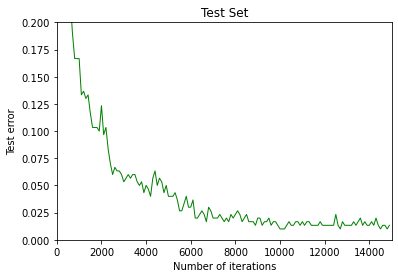

Total time taken is :  269.72924919199977


In [68]:
# Start training the model
epochs= 15000
start = timeit.default_timer()

training_drop(x_train, y_train, firstNN, epochs, opti, criterion)

end = timeit.default_timer()
print("Total time taken is : ", end - start)

In [69]:
# Training accuracy

postout = firstNN(x_train[:training_size, :].reshape(training_size,784),2000)

correct = torch.eq(torch.max(postout, 1)[1], torch.max(y_train[0:training_size, :].reshape(training_size,10), 1)[1]).sum()
print(correct)
print("Training accuracy is : ", 100 * correct.item()/ training_size )

tensor(2992, device='cuda:0')
Training accuracy is :  99.73333333333333


In [70]:
# # Testing accuracy

myXtest = x_test[0:30*test_size, :].reshape(30*test_size, 784)
myYtest = y_test[0:30*test_size, :].reshape(30*test_size, 10)


y_outtest = firstNN(myXtest,2000)
lossNNtest = criterion(y_outtest, torch.max(myYtest, 1)[1])

correct_test = torch.eq(torch.max(y_outtest, 1)[1], torch.max(myYtest, 1)[1]).sum()
print("Number of correct predictions : ", correct_test.item(), ", Test accuracy is : ", 100 * correct_test.item()/ (30*test_size) )


Number of correct predictions :  8820 , Test accuracy is :  98.0
